Importing libraries


In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
import xgboost as xg
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

Opening csv file

In [90]:
def open_csv_clean():
    path_to_data_csv = Path.cwd().parent.parent / "data" / "_properties_data_clean.csv"
    data_prop = pd.read_csv(path_to_data_csv)
    return data_prop


data_prop = open_csv_clean()
pd.set_option('display.max_columns', 48)
display(data_prop)
parent_directory = Path.cwd().parent


,Unnamed: 0,id,URL,Status,transactionType,transactionSubtype,price,type,subtype,country,region,province,district,locality,postalCode,street,number,box,floor,latitude,longitude,bedroomCount,netHabitableSurface,constructionYear,...,floorCount,condition,hasLift,kitchen,hasGarden,gardenSurface,hasTerrace,terraceSurface,land,fireplaceExists,hasSwimmingPool,hasAirConditioning,bathroomCount,showerRoomCount,toiletCount,parkingCountIndoor,parkingCountOutdoor,parkingCountClosedBox,primaryEnergyConsumptionPerSqm,epcScore,hasDoubleGlazing,saleType,creationDate,lastModificationDate
0,0,10616910,https://www.immoweb.be/en/classified/10616910,200,For_sale,Buy_regular,399000.0,Apartment,Apartment,Belgium,Flanders,Limburg,Hasselt,Heusden,3550,Korenhof,14,11,1.0,51.0190223,5.3074674,2.0,125.0,2013.0,...,No_information,As_new,True,Installed,No_information,No_information,True,24.0,No_information,False,False,False,1.0,0.0,1.0,1.0,1.0,No_information,142.0,B,True,No_information,2023-06-07T07:39:57.000+0000,2023-06-07T07:39:59.080+0000
1,1,10616880,https://www.immoweb.be/en/classified/10616880,200,For_sale,Buy_regular,218000.0,Apartment,Apartment,Belgium,Flanders,Antwerp,Turnhout,Mol,2400,Corbiestraat,98,6,1.0,51.1899696,5.1161747,2.0,85.0,No_information,...,No_information,Good,False,Installed,No_information,No_information,True,No_information,No_information,False,False,No_information,No_information,0.0,1.0,No_information,No_information,No_information,92.0,A,True,No_information,2023-06-07T07:22:33.000+0000,2023-07-05T08:30:20.607+0000
2,2,10616933,https://www.immoweb.be/en/classified/10616933,200,For_sale,Buy_regular,95000.0,Apartment,Apartment,Belgium,Flanders,West Flanders,Roeselare,Roeselare,8800,Meensesteenweg,30,2B,2.0,50.9415404,3.1221493,1.0,41.0,No_information,...,No_information,To_be_done_up,True,Installed,No_information,No_information,No_information,No_information,No_information,False,False,No_information,No_information,0.0,1.0,No_information,No_information,No_information,521.0,F,No_information,No_information,2023-06-07T07:52:35.000+0000,2023-07-05T08:28:15.563+0000
3,3,10616917,https://www.immoweb.be/en/classified/10616917,200,For_sale,Buy_regular,169000.0,Apartment,Apartment,Belgium,Flanders,West Flanders,Veurne,De panne,8660,Kasteelstraat,9,No_information,0.0,51.0979245,2.5921772,1.0,No_information,No_information,...,No_information,No_information,No_information,Installed,No_information,No_information,No_information,No_information,No_information,False,No_information,No_information,No_information,0.0,No_information,No_information,No_information,No_information,391.0,D,True,No_information,2023-06-07T07:47:23.000+0000,2023-07-05T08:19:08.357+0000
4,4,10616913,https://www.immoweb.be/en/classified/10616913,200,For_sale,Buy_regular,359000.0,Apartment,Apartment,Belgium,Flanders,Antwerp,Antwerp,Antwerpen,2050,August vermeylenlaan,3,37,7.0,51.2327208,4.3788345,3.0,110.0,No_information,...,No_information,As_new,True,Installed,True,1.0,True,1.0,No_information,False,False,False,No_information,0.0,No_information,No_information,No_information,No_information,140.0,B,False,No_information,2023-06-07T07:44:08.000+0000,2023-06-07T07:44:09.170+0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19067,19974,10616805,https://www.immoweb.be/en/classified/10616805,200,For_sale,Buy_regular,695000.0,Apartment,Apartment,Belgium,Flanders,West Flanders,Brugge,Knokke,8300,No_information,No_information,No_information,1.0,No_information,No_information,2.0,74.0,2004.0,...,4.0,As_new,True,Installed,No_information,No_information,True,4.0,No_information,False,No_information,No_information,2.0,0.0,2.0,No_information,No_information,No_information,93.0,A,True,No_information,2023-06-07T06:47:04.000+0000,2023-07-05T08:21:00.720+0000
19068,19975,10616803,https://www.immoweb.be/en/classified/10616803,200,For_sale,Buy_regular,740000.0

Spliting dataframe for houses and apartments  

In [91]:
def split_types():
    data_apartments = data_prop[data_prop['type'] == 'Apartment']
    data_houses = data_prop[data_prop['type'] == 'House']
    return data_apartments, data_houses


data_apartments, data_houses = split_types()
print('Shape of apartments data:', data_apartments.shape)
print('Shape of houses data:',  data_houses.shape)


Shape of apartments data: (9379, 49)
Shape of houses data: (9693, 49)


CLearning apartment data

In [92]:
def apartment_clean():
    data_apartments_clean = data_apartments[[
        'price', 'floor', 'bedroomCount', 'netHabitableSurface', 'bathroomCount', 'condition']]

    rows_with_no_information = data_apartments_clean.loc[(data_apartments_clean['floor'] == 'No_information') |
                                                         (data_apartments_clean['bedroomCount'] == 'No_information') |
                                                         (data_apartments_clean['bathroomCount'] == 'No_information') |
                                                         (data_apartments_clean['netHabitableSurface'] == 'No_information') |
                                                         (data_apartments_clean['condition'] == 'No_information')]

    rows_to_drop = data_apartments_clean.index.isin(
        rows_with_no_information.index)
    data_apartments_clean = data_apartments_clean[~rows_to_drop]

    data_apartments_clean['condition'].replace(
        {'To_be_done_up': 0, 'To_restore': 1, 'To_renovate': 2, 'Just_renovated': 3, 'Good': 4, "As_new": 5}, inplace=True)

    data_apartments_clean = data_apartments_clean.apply(
        pd.to_numeric, errors='coerce')
    data_apartments_clean[['price', 'floor', 'bedroomCount', 'netHabitableSurface', 'bathroomCount', 'condition']] = data_apartments_clean[[
        'price', 'floor', 'bedroomCount', 'netHabitableSurface', 'bathroomCount', 'condition']].astype('int64')

    data_apartments_clean = data_apartments_clean[(
        data_apartments_clean['floor'] < 17)]
    data_apartments_clean = data_apartments_clean[(
        data_apartments_clean['bedroomCount'] < 7)]
    data_apartments_clean = data_apartments_clean[(
        data_apartments_clean['bathroomCount'] <= 3)]
    data_apartments_clean = data_apartments_clean[(
        data_apartments_clean['netHabitableSurface'] < 350)]
    data_apartments_clean = data_apartments_clean[(
        data_apartments_clean['price'] < 2500000)]

    return data_apartments_clean


data_apartments_clean = apartment_clean()

display(data_apartments_clean)

,price,floor,bedroomCount,netHabitableSurface,bathroomCount,condition
0,399000,1,2,125,1,5
6,423000,2,3,155,1,5
7,169000,0,1,54,1,5
8,275000,1,1,66,1,5
9,185000,3,2,74,1,4
...,...,...,...,...,...,...
19066,650000,0,3,130,2,4
19067,695000,1,2,74,2,5
19068,740000,0,3,170,2,5
19069,317500,0,3,127,1,5


Cleaning house data

In [93]:
def house_clean():
    data_houses_clean = data_houses[[
        'price', 'bedroomCount', 'bathroomCount', 'netHabitableSurface', 'condition']]

    rows_with_no_information_1 = data_houses_clean.loc[(data_houses_clean['bedroomCount'] == 'No_information') |
                                                       (data_houses_clean['bathroomCount'] == 'No_information') |
                                                       (data_houses_clean['netHabitableSurface'] == 'No_information') |
                                                       (data_houses_clean['condition'] == 'No_information')]

    rows_to_drop = data_houses_clean.index.isin(
        rows_with_no_information_1.index)
    data_houses_clean = data_houses_clean[~rows_to_drop]

    data_houses_clean['condition'].replace(
        {'To_be_done_up': 0, 'To_restore': 1, 'To_renovate': 2, 'Just_renovated': 3, 'Good': 4, "As_new": 5}, inplace=True)

    data_houses_clean = data_houses_clean.apply(pd.to_numeric, errors='coerce')
    data_houses_clean[['price', 'bedroomCount', 'netHabitableSurface', 'bathroomCount', 'condition']] = data_houses_clean[[
        'price', 'bedroomCount', 'netHabitableSurface', 'bathroomCount', 'condition']].astype('int64')

    data_houses_clean = data_houses_clean[(
        data_houses_clean['price'] < 3500000)]
    data_houses_clean = data_houses_clean[(
        data_houses_clean['bathroomCount'] <= 8)]
    data_houses_clean = data_houses_clean[(
        data_houses_clean['bedroomCount'] <= 12)]
    data_houses_clean = data_houses_clean[(
        data_houses_clean['netHabitableSurface'] < 700)]

    return data_houses_clean


data_houses_clean = house_clean()

display(data_houses_clean)


,price,bedroomCount,bathroomCount,netHabitableSurface,condition
37,225000,4,1,180,5
46,180000,3,1,148,2
67,650000,5,3,330,4
84,412000,4,2,209,5
85,398000,4,1,141,5
...,...,...,...,...,...
18927,640000,3,2,210,5
18928,285000,5,1,142,0
18956,269000,3,1,160,2
19017,249000,4,1,161,3


Defining Target and Features

In [94]:
def targ_feature_apartment(df_apart):
    y_ap = df_apart['price'].values
    X_ap = df_apart[['floor', 'bedroomCount',
                     'netHabitableSurface', 'bathroomCount', 'condition']].values
    return y_ap, X_ap


def targ_feature_house(df_houses):
    y_h = df_houses['price'].values
    X_h = df_houses[['bedroomCount', 'bathroomCount',
                     'netHabitableSurface', 'condition']].values
    return y_h, X_h


y_apart, X_apart = targ_feature_apartment(data_apartments_clean)
y_houses, X_houses = targ_feature_house(data_houses_clean)

print('Shape of target apartments data:', y_apart.shape,
      'Shape of features apartments data:', X_apart.shape)
print('Shape of target houses data:', y_houses.shape,
      'Shape of features houses dara:', X_houses.shape)

Shape of target apartments data: (5458,) Shape of features apartments data: (5458, 5)
Shape of target houses data: (5573,) Shape of features houses dara: (5573, 4)


Visualizing dataset on a scatter plot: Apartments

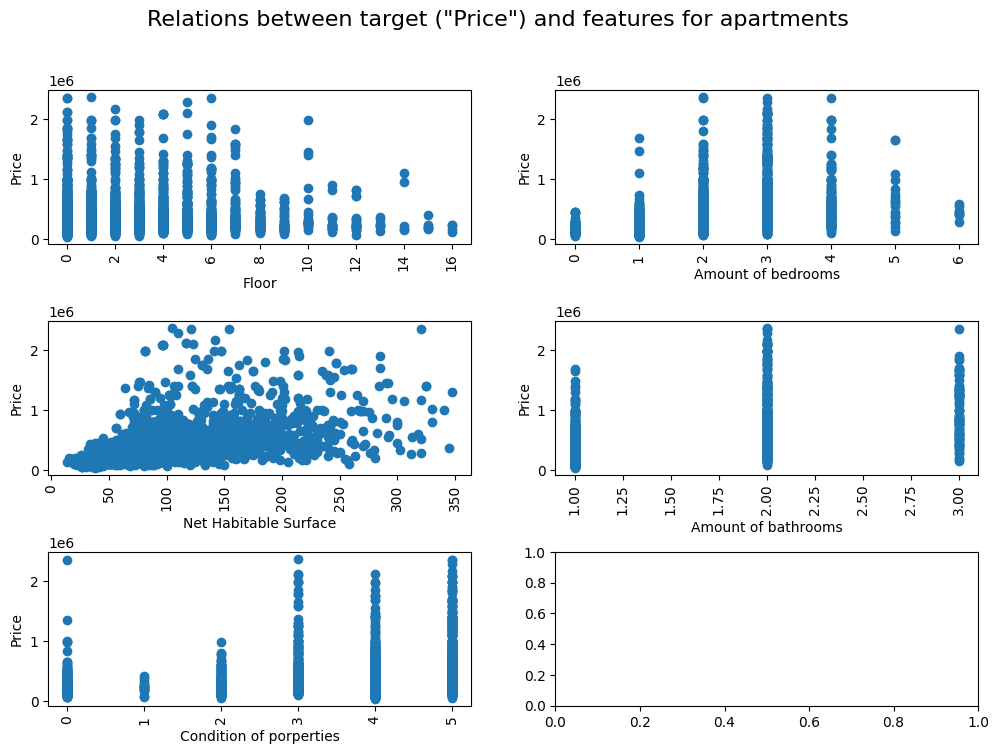

In [95]:
def vis_data_apart(df_apart):
    # Doubles the size of the figure
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

    fig.suptitle('Relations between target ("Price") and features for apartments', fontsize=16)

    # Sort the data by x-values
    sorted_data = df_apart.sort_values('floor')

    axes[0, 0].scatter(sorted_data['floor'], sorted_data['price'])
    axes[0, 0].set_xlabel('Floor')
    axes[0, 0].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[0, 0].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_apart.sort_values('bedroomCount')

    axes[0, 1].scatter(sorted_data['bedroomCount'], sorted_data['price'])
    axes[0, 1].set_xlabel('Amount of bedrooms')
    axes[0, 1].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[0, 1].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_apart.sort_values('netHabitableSurface')

    axes[1, 0].scatter(sorted_data['netHabitableSurface'],
                       sorted_data['price'])
    axes[1, 0].set_xlabel('Net Habitable Surface')
    axes[1, 0].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[1, 0].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_apart.sort_values('bathroomCount')

    axes[1, 1].scatter(sorted_data['bathroomCount'], sorted_data['price'])
    axes[1, 1].set_xlabel('Amount of bathrooms')
    axes[1, 1].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[1, 1].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_apart.sort_values('condition')

    axes[2, 0].scatter(sorted_data['condition'], sorted_data['price'])
    axes[2, 0].set_xlabel('Condition of porperties')
    axes[2, 0].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[2, 0].tick_params(axis='x', rotation=90)

    output_path = Path.cwd().parent.parent / "output" / "plot_MB_1.png"

    plt.savefig(output_path)

    plt.show()  # Display the plott


vis_data_apart(data_apartments_clean)

Visualizing dataset on a scatter plot: Houses

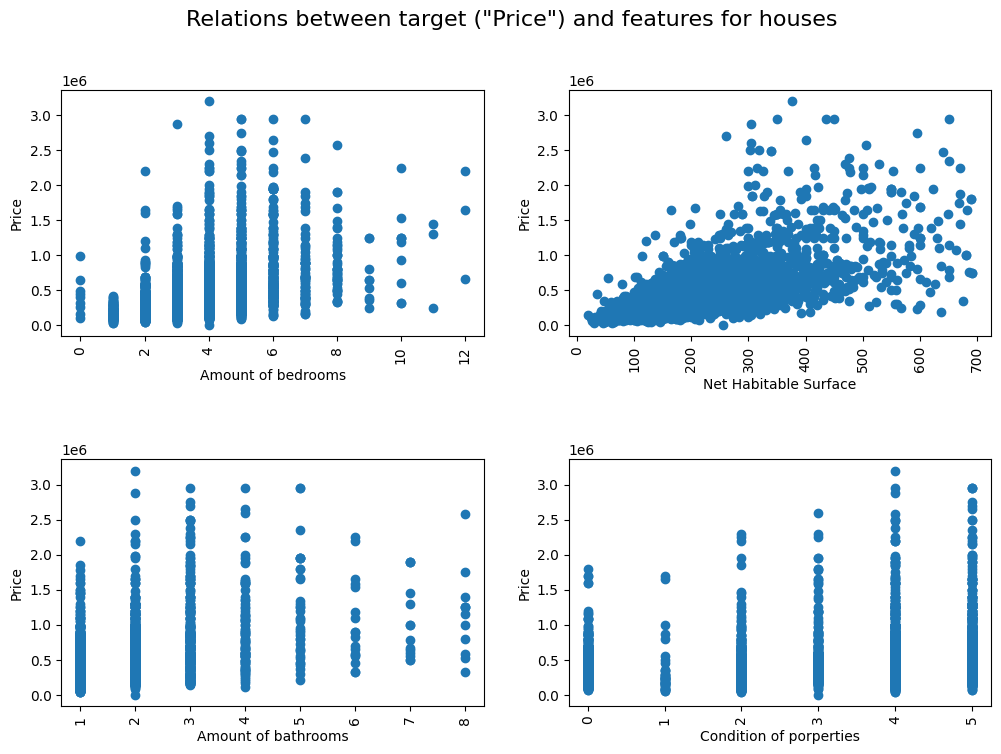

In [96]:
def vis_data_house(df_houses):
    # Doubles the size of the figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

    fig.suptitle('Relations between target ("Price") and features for houses', fontsize=16)

    # Sort the data by x-values
    sorted_data = df_houses.sort_values('bedroomCount')

    axes[0, 0].scatter(sorted_data['bedroomCount'], sorted_data['price'])
    axes[0, 0].set_xlabel('Amount of bedrooms')
    axes[0, 0].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[0, 0].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_houses.sort_values('netHabitableSurface')

    axes[0, 1].scatter(sorted_data['netHabitableSurface'],
                       sorted_data['price'])
    axes[0, 1].set_xlabel('Net Habitable Surface')
    axes[0, 1].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[0, 1].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_houses.sort_values('bathroomCount')

    axes[1, 0].scatter(sorted_data['bathroomCount'], sorted_data['price'])
    axes[1, 0].set_xlabel('Amount of bathrooms')
    axes[1, 0].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[1, 0].tick_params(axis='x', rotation=90)

    # Sort the data by x-values
    sorted_data = df_houses.sort_values('condition')

    axes[1, 1].scatter(sorted_data['condition'], sorted_data['price'])
    axes[1, 1].set_xlabel('Condition of porperties')
    axes[1, 1].set_ylabel('Price')
    # Rotate x-axis label vertically
    axes[1, 1].tick_params(axis='x', rotation=90)

    output_path = Path.cwd().parent.parent / "output" / "plot_MB_2.png"

    plt.savefig(output_path)

    plt.show()  # Display the plott


vis_data_house(data_houses_clean)

Defining correlation

In [97]:
display(data_apartments_clean.corr())
display(data_houses_clean.corr())

,price,floor,bedroomCount,netHabitableSurface,bathroomCount,condition
price,1.000000,0.062688,0.398514,0.527951,0.587638,0.163277
floor,0.062688,1.000000,-0.005310,-0.039485,0.029227,-0.058827
bedroomCount,0.398514,-0.005310,1.000000,0.700814,0.428689,0.001560
netHabitableSurface,0.527951,-0.039485,0.700814,1.000000,0.505038,0.052171
bathroomCount,0.587638,0.029227,0.428689,0.505038,1.000000,0.067467
condition,0.163277,-0.058827,0.001560,0.052171,0.067467,1.000000


,price,bedroomCount,bathroomCount,netHabitableSurface,condition
price,1.000000,0.460376,0.511581,0.650624,0.216287
bedroomCount,0.460376,1.000000,0.560104,0.637968,0.060875
bathroomCount,0.511581,0.560104,1.000000,0.517181,0.095741
netHabitableSurface,0.650624,0.637968,0.517181,1.000000,0.105146
condition,0.216287,0.060875,0.095741,0.105146,1.000000


Spliting data for tests

In [98]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test


# Spliting for apartment
X_train_apart, X_test_apart, y_train_apart, y_test_apart = split_data(
    X_apart, y_apart)
print('Shape of training and testing data for apartments:',
      X_train_apart.shape, X_test_apart.shape)  # print(X_train_apart, X_test_apart)


# Spliting for houses
X_train_houses, X_test_houses, y_train_houses, y_test_houses = split_data(
    X_houses, y_houses)
print('Shape of training and testing data for houses:', X_train_houses.shape,
      X_test_houses.shape)  # print(X_train_houses, X_test_houses)

Shape of training and testing data for apartments: (4093, 5) (1365, 5)
Shape of training and testing data for houses: (4179, 4) (1394, 4)


Fiting models for apartment and houses


In [99]:
def fit_model(X_train, y_train):
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor.score(X_train, y_train), regressor


score_apart, regressor_apart = fit_model(X_train_apart, y_train_apart)
score_houses, regressor_houses = fit_model(X_train_houses, y_train_houses)

Testing models for apartments and houses

In [100]:
def test_model(X_test, regressor):
    y_pred = regressor.predict(X_test)
    return y_pred


y_pred_apart = test_model(X_test_apart, regressor_apart)
y_pred_houses = test_model(X_test_houses, regressor_houses)
mse_apart = mean_squared_error(y_test_apart, y_pred_apart)
mae_apart = mean_absolute_error(y_test_apart, y_pred_apart)
mse_houses = mean_squared_error(y_test_houses, y_pred_houses)
mae_houses = mean_absolute_error(y_test_houses, y_pred_houses)
display(X_test_apart)

array([[  3,   2,  75,   1,   4],
       [  1,   2, 110,   1,   4],
       [  1,   2,  85,   1,   5],
       ...,
       [  1,   1,  72,   1,   5],
       [  3,   3, 110,   1,   3],
       [  2,   3, 132,   2,   5]], dtype=int64)

Printing results for apartment data

In [101]:
print("Accuracy (Regressor score) on apartments training set (Linear Regression):", score_apart)
print("Accuracy (Regressor score) on apartments testing set (Linear Regression):",
      regressor_apart.score(X_test_apart, y_test_apart))
print("Mean Squared Error (MSE) for apartments testing set (Linear Regression):", mse_apart)
print("Mean Absolute Error (MAE) for apartments testing set (Linear Regression):", mae_apart)

Accuracy (Regressor score) on apartments training set (Linear Regression): 0.4372465955948186
Accuracy (Regressor score) on apartments testing set (Linear Regression): 0.4303027611140021
Mean Squared Error (MSE) for apartments testing set (Linear Regression): 37060465559.94048
Mean Absolute Error (MAE) for apartments testing set (Linear Regression): 108194.16457663148


Printing results for houses data

In [102]:
print("Accuracy (Regressor score) on houses training set (Linear Regression):", score_houses)
print("Accuracy (Regressor score) on houses testing set (Linear Regression):",
      regressor_houses.score(X_test_houses, y_test_houses))
print("Mean Squared Error (MSE) for houses testing set (Linear Regression):", mse_houses)
print("Mean Absolute Error (MAE) for houses testing set (Linear Regression):", mae_houses)

Accuracy (Regressor score) on houses training set (Linear Regression): 0.4671324465644128
Accuracy (Regressor score) on houses testing set (Linear Regression): 0.5317962360701152
Mean Squared Error (MSE) for houses testing set (Linear Regression): 49355641709.684555
Mean Absolute Error (MAE) for houses testing set (Linear Regression): 137768.99381868585


Visualizing predictions for apartments

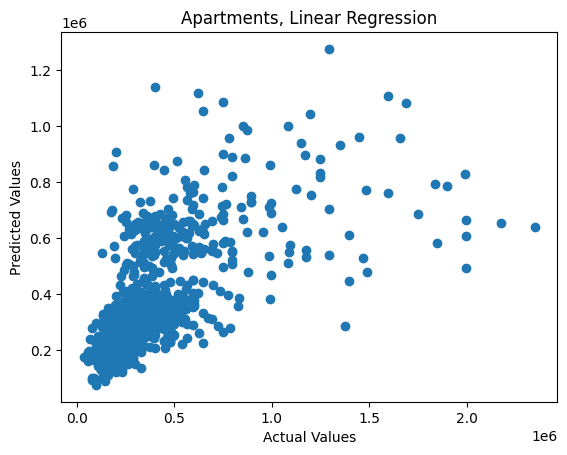

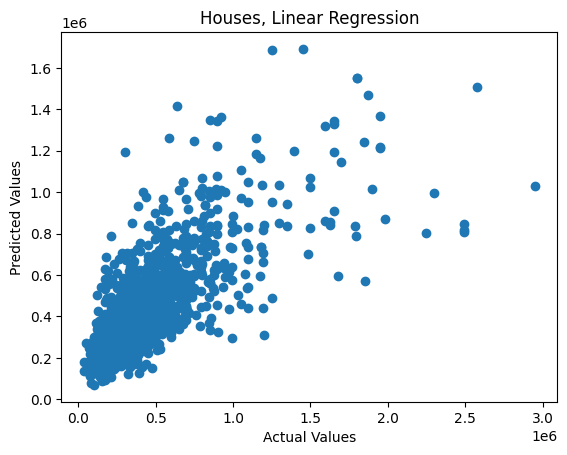

In [103]:
def scatter_pred(y_test, y_pred, type, model):
    plt.scatter(y_test, y_pred)
    plt.title(type + ' ' + model)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")

output_path = Path.cwd().parent.parent / "output" / "plot_MB_3.png"
scatter_pred(y_test_apart, y_pred_apart, 'Apartments,', 'Linear Regression')
plt.savefig(output_path)
plt.show()
output_path = Path.cwd().parent.parent / "output" / "plot_MB_4.png"
scatter_pred(y_test_houses, y_pred_houses, 'Houses,', 'Linear Regression')
plt.savefig(output_path)
plt.show()

Normalization X_train, X-test for apartments

In [104]:
def normal_data(X_train, X_test):
    scaler = preprocessing.MinMaxScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n = scaler.transform(X_test)
    return X_train_n, X_test_n

X_train_apart_n, X_test_apart_n = normal_data(X_train_apart, X_test_apart)

print('Shape of normalized X_train_apart:', X_train_apart_n.shape)
print('Shape of normalized X_test_apart:', X_test_apart_n.shape)

Shape of normalized X_train_apart: (4093, 5)
Shape of normalized X_test_apart: (1365, 5)


Normalizing X_train and X_test for houses


In [105]:
X_train_houses_n, X_test_houses_n = normal_data(X_train_houses, X_test_houses)

print('Shape of normalized X_train_houses:', X_train_houses_n.shape)
print('Shape of normalized X_test_houses:', X_test_houses_n.shape)


Shape of normalized X_train_houses: (4179, 4)
Shape of normalized X_test_houses: (1394, 4)


Fitting and testing normalized data

In [106]:
score_apart_n, regressor_apart_n = fit_model(X_train_apart_n, y_train_apart)
score_houses_n, regressor_houses_n = fit_model(
    X_train_houses_n, y_train_houses)
y_pred_apart_n = test_model(X_test_apart_n, regressor_apart_n)
y_pred_houses_n = test_model(X_test_houses_n, regressor_houses_n)

mse_apart_n = mean_squared_error(y_test_apart, y_pred_apart_n)
mae_apart_n = mean_absolute_error(y_test_apart, y_pred_apart_n)
mse_houses_n = mean_squared_error(y_test_houses, y_pred_houses_n)
mae_houses_n = mean_absolute_error(y_test_houses, y_pred_houses_n)

Printing results of training and testing for apartments data

In [107]:
print("Accuracy (Regressor score) on apartments training set (Linear Regression) with normalized data:", score_apart_n)
print("Accuracy (Regressor score) on apartments testing set (Linear Regression) with normalized data:",
      regressor_apart_n.score(X_test_apart_n, y_test_apart))
print("Mean Squared Error (MSE) for apartments testing set (Linear Regression) with normalized data:", mse_apart_n)
print("Mean Absolute Error (MAE) for apartments testing set (Linear Regression) with normalized data:", mae_apart_n)

Accuracy (Regressor score) on apartments training set (Linear Regression) with normalized data: 0.4372465955948185
Accuracy (Regressor score) on apartments testing set (Linear Regression) with normalized data: 0.43030276111400223
Mean Squared Error (MSE) for apartments testing set (Linear Regression) with normalized data: 37060465559.940475
Mean Absolute Error (MAE) for apartments testing set (Linear Regression) with normalized data: 108194.16457663164


Printing results of training and testing for houses data

In [108]:
print("Accuracy (Regressor score) on houses training set (Linear Regression) with normalized data:", score_houses_n)
print("Accuracy (Regressor score) on houses testing set (Linear Regression) with normalized data:",
      regressor_houses_n.score(X_test_houses_n, y_test_houses))
print("Mean Squared Error (MSE) for houses testing set (Linear Regression) with normalized data:", mse_houses_n)
print("Mean Absolute Error (MAE) for houses testing set (Linear Regression) with normalized data:", mae_houses_n)

Accuracy (Regressor score) on houses training set (Linear Regression) with normalized data: 0.4671324465644128
Accuracy (Regressor score) on houses testing set (Linear Regression) with normalized data: 0.5317962360701152
Mean Squared Error (MSE) for houses testing set (Linear Regression) with normalized data: 49355641709.68455
Mean Absolute Error (MAE) for houses testing set (Linear Regression) with normalized data: 137768.99381868573


Visualization of prediction on normalized data

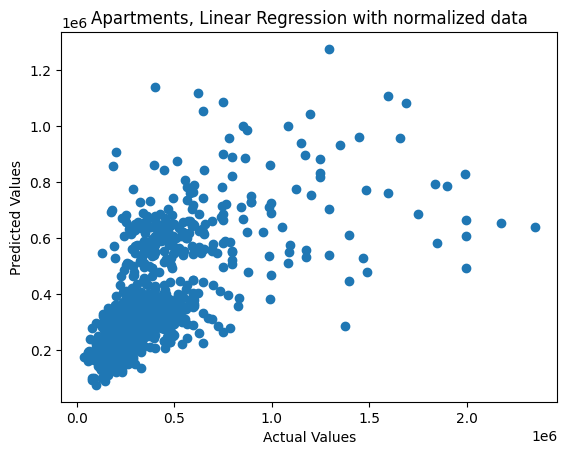

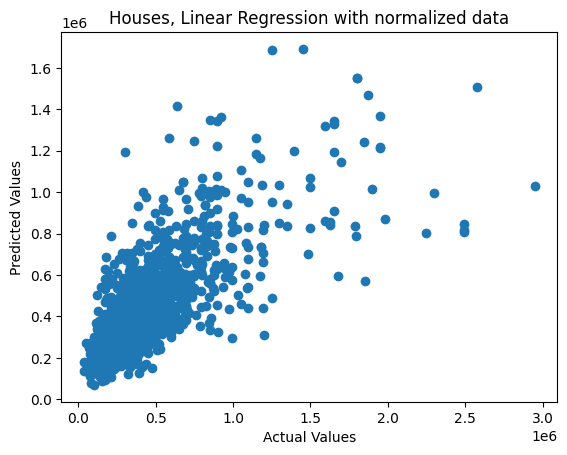

In [109]:
output_path = Path.cwd().parent.parent / "output" / "plot_MB_5.png"
scatter_pred(y_test_apart, y_pred_apart_n, 'Apartments,',
             'Linear Regression with normalized data')
plt.savefig(output_path)
plt.show()
output_path = Path.cwd().parent.parent / "output" / "plot_MB_6.png"
scatter_pred(y_test_houses, y_pred_houses_n, 'Houses,',
             'Linear Regression with normalized data')
plt.savefig(output_path)
plt.show()

Building decision tree

In [110]:
def tree(X_train, y_train, X_test, y_test):
    # tree = DecisionTreeRegressor(ccp_alpha=0.00005)
    tree = DecisionTreeRegressor(min_samples_split=64)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    return y_pred, tree.score(X_train, y_train), tree.score(X_test, y_test)


y_pred_apart_tree, tree_tr_score_apart, tree_test_score_apart = tree(
    X_train_apart_n, y_train_apart, X_test_apart_n, y_test_apart)
y_pred_houses_tree, tree_tr_score_houses, tree_test_score_houses = tree(
    X_train_houses_n, y_train_houses, X_test_houses_n, y_test_houses)

mse_apart_tree = mean_squared_error(y_test_apart, y_pred_apart_tree)
mae_apart_tree = mean_absolute_error(y_test_apart, y_pred_apart_tree)
mse_houses_tree = mean_squared_error(y_test_houses, y_pred_houses_tree)
mae_houses_tree = mean_absolute_error(y_test_houses, y_pred_houses_tree)

Printing results for apartments (Decision tree)

In [111]:
print("Accuracy (Regressor score) on apartments training set (Decision Tree) with normalized data:", tree_tr_score_apart)
print("Accuracy (Regressor score) on apartments testing set (Decision Tree) with normalized data:",
      tree_test_score_apart)
print("Mean Squared Error (MSE) for apartments testing set (Decision Tree) with normalized data:", mse_apart_tree)
print("Mean Absolute Error (MAE) for apartments testing set (Decision Tree) with normalized data:", mae_apart_tree)

Accuracy (Regressor score) on apartments training set (Decision Tree) with normalized data: 0.5446163674634793
Accuracy (Regressor score) on apartments testing set (Decision Tree) with normalized data: 0.4574346901479265
Mean Squared Error (MSE) for apartments testing set (Decision Tree) with normalized data: 35295454510.38242
Mean Absolute Error (MAE) for apartments testing set (Decision Tree) with normalized data: 104868.06438434709


Printing results for houses (Decision tree)

In [112]:
print("Accuracy (Regressor score) on houses training set (Decision Tree) with normalized data:", tree_tr_score_houses)
print("Accuracy (Regressor score) on houses testing set (Decision Tree) with normalized data:",
      tree_test_score_houses)
print("Mean Squared Error (MSE) for houses testing set (Decision Tree) with normalized data:", mse_houses_tree)
print("Mean Absolute Error (MAE) for houses testing set (Decision Tree) with normalized data:", mae_houses_tree)

Accuracy (Regressor score) on houses training set (Decision Tree) with normalized data: 0.5809894565888893
Accuracy (Regressor score) on houses testing set (Decision Tree) with normalized data: 0.42902420312176126
Mean Squared Error (MSE) for houses testing set (Decision Tree) with normalized data: 60189342817.50917
Mean Absolute Error (MAE) for houses testing set (Decision Tree) with normalized data: 148108.24615180807


Visualization of prediction for Decision Tree model

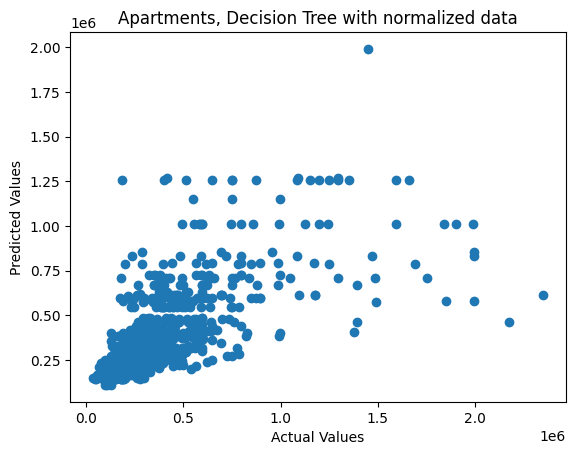

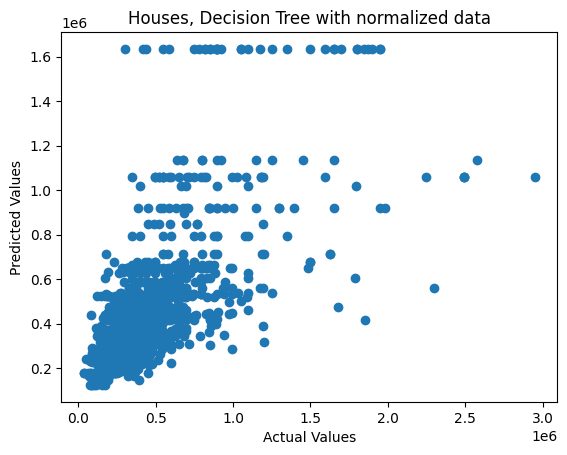

In [113]:
output_path = Path.cwd().parent.parent / "output" / "plot_MB_7.png"
scatter_pred(y_test_apart, y_pred_apart_tree, 'Apartments,',
             'Decision Tree with normalized data')
plt.savefig(output_path)
plt.show()
output_path = Path.cwd().parent.parent / "output" / "plot_MB_8.png"
scatter_pred(y_test_houses, y_pred_houses_tree, 'Houses,',
             'Decision Tree with normalized data')
plt.savefig(output_path)
plt.show()

Building XGBR model

In [114]:
def xgbr(X_train, y_train, X_test, y_test):
    xgb_r = xg.XGBRegressor(objective='reg:squarederror',
                            n_estimators=10)
    xgb_r.fit(X_train, y_train)
    y_pred = xgb_r.predict(X_test)
    return y_pred, xgb_r.score(X_train, y_train), xgb_r.score(X_test, y_test)


y_pred_apart_xgbr, xgbr_tr_score_apart, xgbr_test_score_apart = xgbr(
    X_train_apart_n, y_train_apart, X_test_apart_n, y_test_apart)
y_pred_houses_xgbr, xgbr_tr_score_houses, xgbr_test_score_houses = xgbr(
    X_train_houses_n, y_train_houses, X_test_houses_n, y_test_houses)
mse_apart_xgbr = mean_squared_error(y_test_apart, y_pred_apart_xgbr)
mae_apart_xgbr = mean_absolute_error(y_test_apart, y_pred_apart_xgbr)
mse_houses_xgbr = mean_squared_error(y_test_houses, y_pred_houses_xgbr)
mae_houses_xgbr = mean_absolute_error(y_test_houses, y_pred_houses_xgbr)

Printing results for apartments (XGBoos Regressor Model)

In [115]:
print("Accuracy (Regressor score) on apartments training set (XGB Regressor) with normalized data:", xgbr_tr_score_apart)
print("Accuracy (Regressor score) on apartments testing set (XGB Regressor) with normalized data:",
      xgbr_test_score_apart)
print(r2_score(y_test_apart, y_pred_apart_xgbr))
print("Mean Squared Error (MSE) for apartments testing set (XGB Regressor) with normalized data:", mse_apart_xgbr)
print("Mean Absolute Error (MAE) for apartments testing set (XGB Regressor) with normalized data:", mae_apart_xgbr)

Accuracy (Regressor score) on apartments training set (XGB Regressor) with normalized data: 0.6362886614492026
Accuracy (Regressor score) on apartments testing set (XGB Regressor) with normalized data: 0.4941993835909043
0.4941993835909043
Mean Squared Error (MSE) for apartments testing set (XGB Regressor) with normalized data: 32903804064.911503
Mean Absolute Error (MAE) for apartments testing set (XGB Regressor) with normalized data: 99492.33731112638


Printing results for houses (XGBoos Regressor Model)

In [116]:
print("Accuracy (Regressor score) on houses training set (XGB Regressor) with normalized data:", xgbr_tr_score_houses)
print("Accuracy (Regressor score) on houses testing set (XGB Regressor) with normalized data:",
      xgbr_test_score_houses)
print(r2_score(y_test_houses, y_pred_houses_xgbr))
print("Mean Squared Error (MSE) for houses testing set (XGB Regressor) with normalized data:", mse_houses_xgbr)
print("Mean Absolute Error (MAE) for houses testing set (XGB Regressor) with normalized data:", mae_houses_xgbr)

Accuracy (Regressor score) on houses training set (XGB Regressor) with normalized data: 0.6718558341648144
Accuracy (Regressor score) on houses testing set (XGB Regressor) with normalized data: 0.4711599047066444
0.4711599047066444
Mean Squared Error (MSE) for houses testing set (XGB Regressor) with normalized data: 55747613060.46025
Mean Absolute Error (MAE) for houses testing set (XGB Regressor) with normalized data: 138524.04349556135


Visualization of prediction (XGBoos Regressor Model)

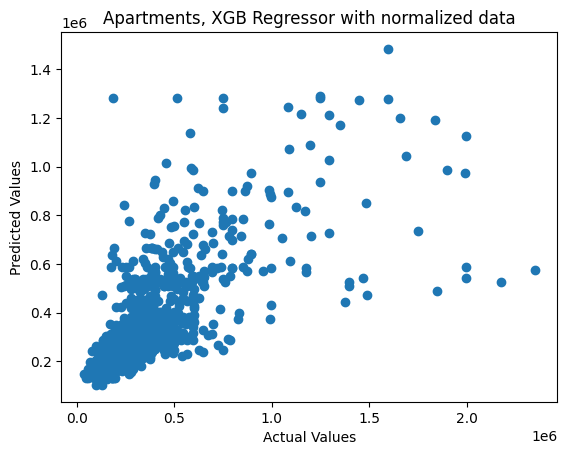

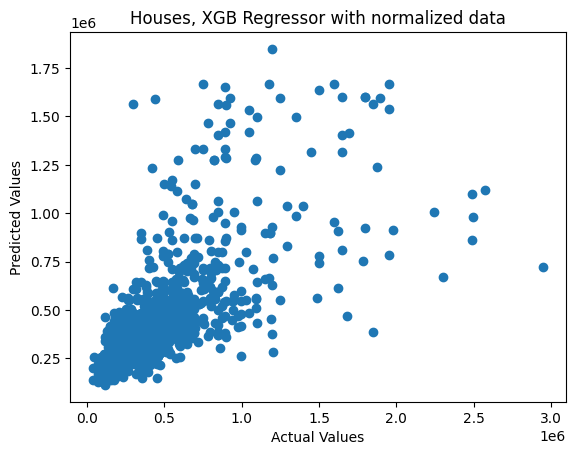

In [117]:
output_path = Path.cwd().parent.parent / "output" / "plot_MB_9.png"
scatter_pred(y_test_apart, y_pred_apart_xgbr, 'Apartments,',
             'XGB Regressor with normalized data')
plt.savefig(output_path)
plt.show()
output_path = Path.cwd().parent.parent / "output" / "plot_MB_10.png"
scatter_pred(y_test_houses, y_pred_houses_xgbr, 'Houses,',
             'XGB Regressor with normalized data')
plt.savefig(output_path)
plt.show()

Building SGDRegressor model

In [118]:
def sgdr(X_train, y_train, X_test, y_test):
    sgdr = SGDRegressor()
    sgdr.fit(X_train, y_train)
    y_pred = sgdr.predict(X_test)
    return y_pred, sgdr.score(X_train, y_train), sgdr.score(X_test, y_test)


y_pred_apart_sgdr, sgdr_tr_score_apart, sgdr_test_score_apart = sgdr(
    X_train_apart_n, y_train_apart, X_test_apart_n, y_test_apart)
y_pred_houses_sgdr, sgdr_tr_score_houses, sgdr_test_score_houses = sgdr(
    X_train_houses_n, y_train_houses, X_test_houses_n, y_test_houses)
mse_apart_sgdr = mean_squared_error(y_test_apart, y_pred_apart_sgdr)
mae_apart_sgdr = mean_absolute_error(y_test_apart, y_pred_apart_sgdr)
mse_houses_sgdr = mean_squared_error(y_test_houses, y_pred_houses_sgdr)
mae_houses_sgdr = mean_absolute_error(y_test_houses, y_pred_houses_sgdr)

Printing results for apartments (SGD Regressor Model)

In [119]:
print("Accuracy (Regressor score) on apartments training set (SGD Regressor) with normalized data:", sgdr_tr_score_apart)
print("Accuracy (Regressor score) on apartments testing set (SGD Regressor) with normalized data:",
      sgdr_test_score_apart)
print("Mean Squared Error (MSE) for apartments testing set (SGD Regressor) with normalized data:", mse_apart_sgdr)
print("Mean Absolute Error (MAE) for apartments testing set (SGD Regressor) with normalized data:", mae_apart_sgdr)

Accuracy (Regressor score) on apartments training set (SGD Regressor) with normalized data: 0.43480837111295323
Accuracy (Regressor score) on apartments testing set (SGD Regressor) with normalized data: 0.4222766889962759
Mean Squared Error (MSE) for apartments testing set (SGD Regressor) with normalized data: 37582584940.196266
Mean Absolute Error (MAE) for apartments testing set (SGD Regressor) with normalized data: 108611.80055355615


Printing results for houses (SGD Regressor Model)

In [120]:
print("Accuracy (Regressor score) on houses training set (SGD Regressor) with normalized data:", sgdr_tr_score_houses)
print("Accuracy (Regressor score) on houses testing set (SGD Regressor) with normalized data:",
      sgdr_test_score_houses)
print("Mean Squared Error (MSE) for houses testing set (SGD Regressor) with normalized data:", mse_houses_sgdr)
print("Mean Absolute Error (MAE) for houses testing set (SGD Regressor) with normalized data:", mae_houses_sgdr)

Accuracy (Regressor score) on houses training set (SGD Regressor) with normalized data: 0.46510928283422515
Accuracy (Regressor score) on houses testing set (SGD Regressor) with normalized data: 0.5292364471124291
Mean Squared Error (MSE) for houses testing set (SGD Regressor) with normalized data: 49625481545.203
Mean Absolute Error (MAE) for houses testing set (SGD Regressor) with normalized data: 137763.820929985


Visualization of prediction (SGD Regressor Model)

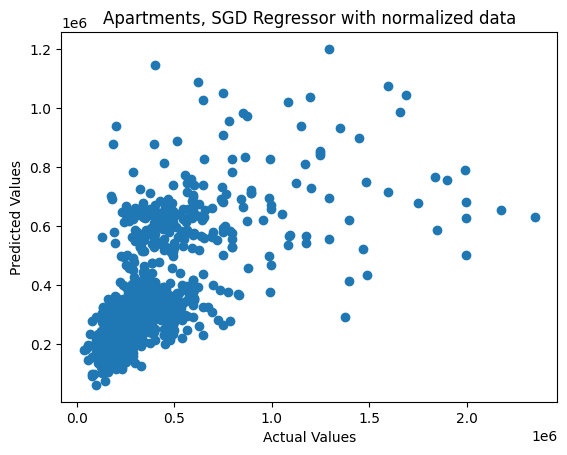

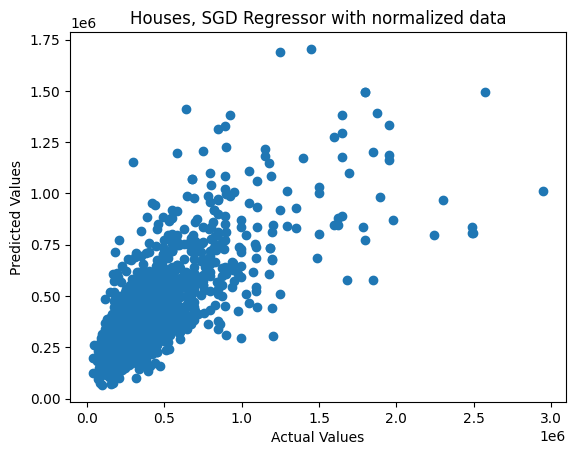

In [121]:
output_path = Path.cwd().parent.parent / "output" / "plot_MB_11.png"
scatter_pred(y_test_apart, y_pred_apart_sgdr, 'Apartments,',
             'SGD Regressor with normalized data')
plt.savefig(output_path)
plt.show()
output_path = Path.cwd().parent.parent / "output" / "plot_MB_12.png"
scatter_pred(y_test_houses, y_pred_houses_sgdr, 'Houses,',
             'SGD Regressor with normalized data')
plt.savefig(output_path)
plt.show()